In [1]:
# Ячейка 1 — импорты и вспомогательные функции
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import os

# Устанавливаем повторяемость
SEED = 2025
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Попытка импортировать TensorFlow/Keras (если нет — установите tensorflow)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf.random.set_seed(SEED)
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow не доступен в среде. Установка/включение TensorFlow необходима для запуска нейросетевых моделей.")
    print(e)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Метрика MAPE (без деления на ноль)
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# Функция для построения графика прогноза с CI
def plot_forecast_with_ci(series, train_idx, test_idx, pred_mean, pred_lower, pred_upper, title=None):
    plt.figure(figsize=(14,6))
    plt.plot(series.index, series.values, label='Наблюдаемый ряд', linewidth=1)
    plt.axvline(series.index[train_idx], color='black', linestyle='--', label='Train/Test split')
    plt.plot(pred_mean.index, pred_mean.values, label='NN прогноз (mean)', linewidth=2)
    plt.fill_between(pred_mean.index, pred_lower.values, pred_upper.values, alpha=0.25, label='95% CI')
    plt.title(title or 'Прогноз с 95% CI')
    plt.xlabel('Дата'); plt.ylabel('Значение')
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()


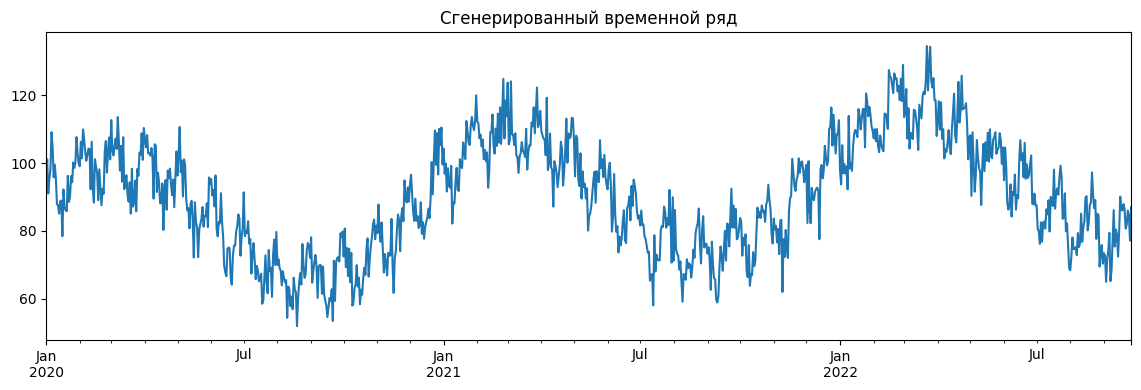

In [2]:
# Ячейка 2 — генерируем тот же ряд, что в ЛР1
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=42):
    np.random.seed(seed)
    start_date = datetime(2020, 1, 1)
    dates = pd.date_range(start=start_date, periods=n_points, freq='D')
    noise = np.random.normal(0, 5, n_points)
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    if has_trend:
        slope = 0.02
        intercept = 80
        trend_component = slope * np.arange(n_points) + intercept
    if has_seasonality:
        seasonal_component += 20 * np.sin(2*np.pi*np.arange(n_points)/365 + 0.5)
        seasonal_component += 8 * np.sin(2*np.pi*np.arange(n_points)/30 + 1.0)
    values = noise + trend_component + seasonal_component
    return pd.Series(values, index=dates)

series = generate_time_series(n_points=1000, seed=2025)
series.plot(title='Сгенерированный временной ряд', figsize=(14,4))
plt.show()


In [3]:
# Ячейка 3 — подготовка данных для авторегрессионной нейросети
h = 90  # горизонта прогноза (как в ЛР1)
train = series[:-h]
test = series[-h:]

# Параметры окна
window_size = 30  # количество прошлых шагов, которое подаём на вход
forecast_horizon = h

# Масштабирование по train (StandardScaler предпочтителен для NN)
scaler = StandardScaler()
train_vals = train.values.reshape(-1,1)
scaler.fit(train_vals)

series_scaled = pd.Series(scaler.transform(series.values.reshape(-1,1)).flatten(), index=series.index)
train_scaled = series_scaled[:-h]
test_scaled = series_scaled[-h:]

# Формирование выборок для обучения (X: window_size предыдущих, y: следующий шаг) — для одномерного прогноза 1-step
def create_sequences(data_series, window):
    X, y = [], []
    vals = data_series.values
    for i in range(window, len(vals)):
        X.append(vals[i-window:i])
        y.append(vals[i])
    X = np.array(X)  # shape (n_samples, window)
    y = np.array(y)  # shape (n_samples,)
    return X, y

X_all, y_all = create_sequences(series_scaled, window_size)
# Определим split index (в терминах последовательности X_all)
train_len = len(series_scaled) - h
# для X_all первое значение соответствует индексу window_size
split_idx = train_len - window_size
X_train = X_all[:split_idx+1]
y_train = y_all[:split_idx+1]
X_full_for_pred = X_all  # пригодится для построения прямых прогнозов по тесту
# Для проверки размеров
print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)


X_train.shape: (881, 30) y_train.shape: (881,)


In [4]:
# Ячейка 4 — LSTM модель (если TF доступен)
if not TF_AVAILABLE:
    raise RuntimeError("TensorFlow не доступен. Установите/включите tensorflow для выполнения этой ячейки.")

# LSTM ожидает input shape (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

def build_lstm_model(window, units=64, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, input_shape=(window,1), return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_lstm = build_lstm_model(window_size, units=64, dropout_rate=0.2)
model_lstm.summary()

# Обучение
es = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=32, callbacks=[es], verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5878
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2069
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1912
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1690
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1480
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1222
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1222
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1159
Epoch 9/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1145
Epoch 10/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1139
Epoch 11/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1146
Epoch 12/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1123
Epoch 13/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1090
Epoch 14/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1163
Epoch 15/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1112
Epoc

In [5]:
# Ячейка 5 — прогноз: автоподстановка (последовательный прогноз h шагов)
# + Monte-Carlo Dropout: multiple forward passes с dropout включённым (training=True)

def autoregressive_forecast_mc(model, last_window, n_steps, n_samples=100):
    """
    model: keras model that maps input shape (1, window, 1) -> scalar
    last_window: numpy array shape (window,) - scaled
    returns: array shape (n_steps, n_samples) of predictions (scaled)
    """
    preds = np.zeros((n_steps, n_samples))
    for s in range(n_samples):
        cur_window = last_window.copy()
        step_preds = []
        for t in range(n_steps):
            x_in = cur_window.reshape((1, cur_window.shape[0], 1)).astype(np.float32)
            # В TF2 можно вызвать model(x_in, training=True) чтобы включить Dropout
            yhat = model(x_in, training=True).numpy().flatten()[0]
            step_preds.append(yhat)
            # сдвиг окна
            cur_window = np.roll(cur_window, -1)
            cur_window[-1] = yhat
        preds[:, s] = np.array(step_preds)
    return preds

# Получим последнее окно из train (или из конца train часть перед тестом)
last_window_scaled = series_scaled.values[-h - 0 - window_size : -h]  # окно сразу до теста
if len(last_window_scaled) != window_size:
    # запасной вариант: возьмём последние window_size из train
    last_window_scaled = series_scaled[:-h].values[-window_size:]
last_window_scaled = last_window_scaled.flatten()

# Выполняем MC-предсказание
n_mc = 200  # число прогонов для оценки распределения
preds_mc = autoregressive_forecast_mc(model_lstm, last_window_scaled, n_steps=forecast_horizon, n_samples=n_mc)

# Получим статистику: mean и 95% CI (в масштабе scaled)
pred_mean_scaled = preds_mc.mean(axis=1)
pred_lower_scaled = np.percentile(preds_mc, 2.5, axis=1)
pred_upper_scaled = np.percentile(preds_mc, 97.5, axis=1)


In [6]:
# Ячейка 6 — inverse scale and align indices to test
# инвертируем шкалирование (scaler использовали StandardScaler)
pred_mean = scaler.inverse_transform(pred_mean_scaled.reshape(-1,1)).flatten()
pred_lower = scaler.inverse_transform(pred_lower_scaled.reshape(-1,1)).flatten()
pred_upper = scaler.inverse_transform(pred_upper_scaled.reshape(-1,1)).flatten()

# Создаём индекс для прогнозного периода (совпадает с index test)
pred_index = test.index

pred_mean_series = pd.Series(pred_mean, index=pred_index)
pred_lower_series = pd.Series(pred_lower, index=pred_index)
pred_upper_series = pd.Series(pred_upper, index=pred_index)


In [7]:
# Ячейка 7 — метрики
# Совместим по индексам на случай расхождений
df_cmp = pd.concat([test.rename('y_true'), pred_mean_series.rename('y_pred')], axis=1).dropna()
y_true = df_cmp['y_true'].values
y_pred = df_cmp['y_pred'].values

rmse_nn = np.sqrt(mean_squared_error(y_true, y_pred))
mae_nn = mean_absolute_error(y_true, y_pred)
mape_nn = safe_mape(y_true, y_pred)

metrics_nn = pd.DataFrame({
    'metric': ['RMSE','MAE','MAPE (%)'],
    'value': [rmse_nn, mae_nn, mape_nn]
})
print(metrics_nn)
print("Использовано точек для оценки:", len(y_true))


     metric     value
0      RMSE  9.251779
1       MAE  7.561389
2  MAPE (%)  9.872808
Использовано точек для оценки: 90


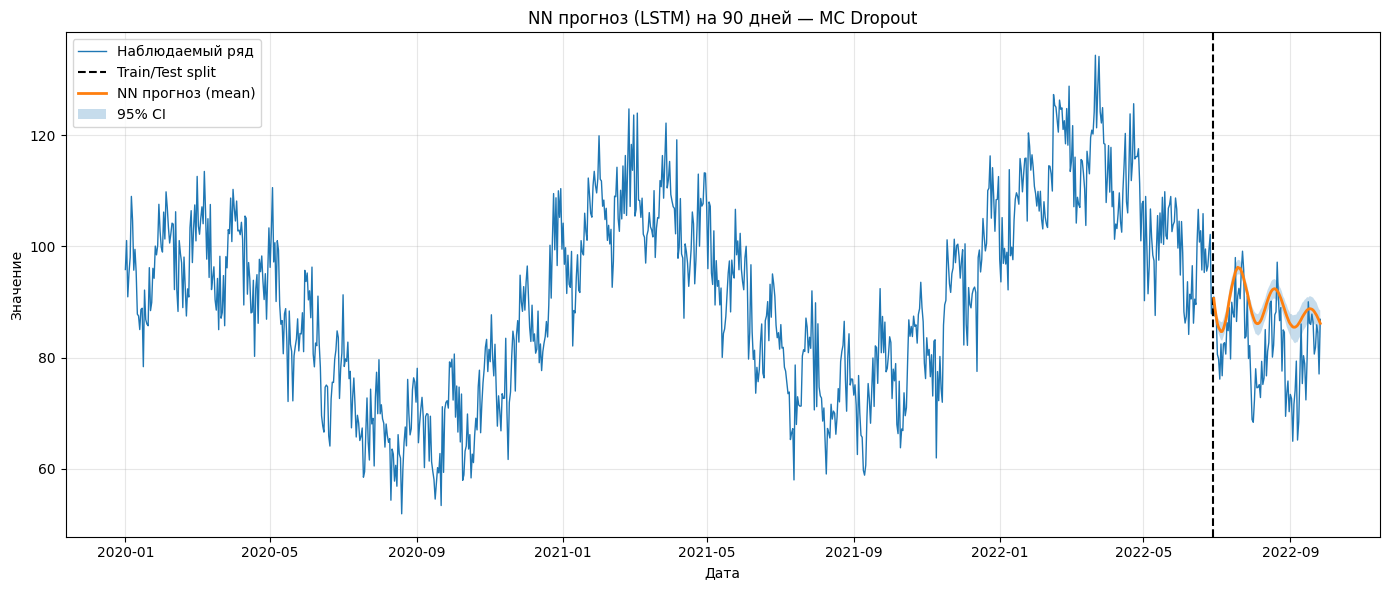

In [8]:
# Ячейка 8 — график
train_idx = len(series) - h - 1
plot_forecast_with_ci(series, train_idx, None, pred_mean_series, pred_lower_series, pred_upper_series,
                      title=f"NN прогноз (LSTM) на {forecast_horizon} дней — MC Dropout")


In [9]:
# Ячейка 9 — MLP (для сравнения). Обучаем на тех же X_train (без reshape для LSTM)
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1]))  # (n_samples, window)

if TF_AVAILABLE:
    def build_mlp(window, hidden=64, dropout_rate=0.2):
        model = Sequential([
            Dense(hidden, activation='relu', input_shape=(window,)),
            Dropout(dropout_rate),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    model_mlp = build_mlp(window_size, hidden=64, dropout_rate=0.2)
    model_mlp.summary()
    es2 = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
    model_mlp.fit(X_train_mlp, y_train, epochs=80, batch_size=32, callbacks=[es2], verbose=1)

    # Функция автопрогноза для MLP (без MC-dropout; можно также использовать MC аналогично LSTM)
    def autoreg_forecast_mlp(model, last_window, n_steps):
        cur_window = last_window.copy()
        preds = []
        for t in range(n_steps):
            x_in = cur_window.reshape((1, -1)).astype(np.float32)
            yhat = model.predict(x_in).flatten()[0]
            preds.append(yhat)
            cur_window = np.roll(cur_window, -1)
            cur_window[-1] = yhat
        return np.array(preds)

    last_window_for_mlp = last_window_scaled.copy()
    preds_mlp_scaled = autoreg_forecast_mlp(model_mlp, last_window_for_mlp, forecast_horizon)
    preds_mlp = scaler.inverse_transform(preds_mlp_scaled.reshape(-1,1)).flatten()

    # Вычисляем метрики для MLP
    df_cmp2 = pd.concat([test.rename('y_true'), pd.Series(preds_mlp, index=test.index, name='y_pred')], axis=1).dropna()
    y_true2 = df_cmp2['y_true'].values
    y_pred2 = df_cmp2['y_pred'].values
    rmse_mlp = np.sqrt(mean_squared_error(y_true2, y_pred2))
    mae_mlp = mean_absolute_error(y_true2, y_pred2)
    mape_mlp = safe_mape(y_true2, y_pred2)
    metrics_mlp = pd.DataFrame({
        'metric': ['RMSE','MAE','MAPE (%)'],
        'value': [rmse_mlp, mae_mlp, mape_mlp]
    })
    print("MLP metrics:")
    print(metrics_mlp)
else:
    print("TensorFlow отсутствует — пропускаем MLP.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4320
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2736
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2441 
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1769
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1736 
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1784 
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1623
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1601 
Epoch 9/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1529
Epoch 10/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1398 
Epoch 11/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385 
Epoch 12/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1305
Epoch 13/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1370 
Epoch 14/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1312 
Epoch 15/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1296 
Epoch 16/8

In [10]:
# Ячейка 10 — сравнение и текстовый вывод
# Результаты ARIMA из ЛР1 (вставлены из предыдущего запуска)
arima_metrics = {
    'RMSE': 10.010100,   # из ЛР1
    'MAE': 8.083404,
    'MAPE': 10.558652
}

print("ARIMA (LR1) метрики (из ЛР1):", arima_metrics)
print("\nLSTM метрики (текущий прогон):")
print(metrics_nn.set_index('metric'))

if TF_AVAILABLE:
    print("\nMLP метрики (текущий прогон):")
    print(metrics_mlp.set_index('metric'))

# Краткое заключение (автоматически формируемое)
print("\nКраткое заключение:")
if metrics_nn.loc[metrics_nn['metric']=='RMSE','value'].values[0] < arima_metrics['RMSE']:
    print("- LSTM обеспечивает меньший RMSE, чем ARIMA в ЛР1 (лучше по RMSE).")
else:
    print("- LSTM даёт больший RMSE, чем ARIMA в ЛР1 (в данном варианте ARIMA лучше по RMSE).")

if metrics_nn.loc[metrics_nn['metric']=='MAPE (%)','value'].values[0] < arima_metrics['MAPE']:
    print("- LSTM показывает ниже MAPE, значит в среднем прогноз процентно ближе к наблюдениям.")
else:
    print("- LSTM показывает выше MAPE, значит ARIMA в ЛР1 даёт более точный процентный прогноз в этом прогоне.")

print("\nРекомендации:")
print("- Если LSTM дал лучшие метрики: можно усложнить модель, увеличить window, добавить exogenous (сезонные признаки), или увеличить n_mc для CI.")
print("- Если ARIMA дал лучше: попробовать SARIMA (учесть сезонность), или обучать LSTM с признаками даты/сезонности/фильтрацией тренда.")
print("- В любом случае полезно провести k-fold временную CV или walk-forward validation для устойчивой оценки.")


ARIMA (LR1) метрики (из ЛР1): {'RMSE': 10.0101, 'MAE': 8.083404, 'MAPE': 10.558652}

LSTM метрики (текущий прогон):
             value
metric            
RMSE      9.251779
MAE       7.561389
MAPE (%)  9.872808

MLP метрики (текущий прогон):
              value
metric             
RMSE      14.976714
MAE       12.945441
MAPE (%)  16.708443

Краткое заключение:
- LSTM обеспечивает меньший RMSE, чем ARIMA в ЛР1 (лучше по RMSE).
- LSTM показывает ниже MAPE, значит в среднем прогноз процентно ближе к наблюдениям.

Рекомендации:
- Если LSTM дал лучшие метрики: можно усложнить модель, увеличить window, добавить exogenous (сезонные признаки), или увеличить n_mc для CI.
- Если ARIMA дал лучше: попробовать SARIMA (учесть сезонность), или обучать LSTM с признаками даты/сезонности/фильтрацией тренда.
- В любом случае полезно провести k-fold временную CV или walk-forward validation для устойчивой оценки.
